In [1]:
#%%capture
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib widget
from tqdm import trange
import am3lib
from RadiatingBlastWave import RadiatingBlastWave
import physicsConsts as c
from transformations import *
from astropy.cosmology import Planck18, WMAP9
import pandas as pd
import setFigureConfig as sfc
from colorschemes import get_comp_cols
compcols = get_comp_cols()
from gridSearchFunctions import plot_logfaderange, plot_concept, plot_coolingtimes, fluence_int, light_curve_int, dens2flux_av, plot_spectrum_norbw
from scipy.interpolate import griddata, LinearNDInterpolator
from astropy.cosmology import Planck18, WMAP9

ModuleNotFoundError: No module named 'RadiatingBlastWave'

In [2]:
%matplotlib widget
def get_AM3(exp=1, hadronic=1):
    am3 = am3lib.AM3()
    am3.update_energy_grid(1e-6, 1e3, 1e22)
    # set switches
    am3.set_estimate_max_energies(0)

    am3.set_process_parse_sed(1)
    am3.set_process_hadronic(hadronic)
    am3.set_process_merge_positrons_into_electrons(0)
    am3.set_process_escape(1)
    # expansion related
    am3.set_process_adiabatic_cooling(1)
    am3.set_process_expansion(exp)

    # synchrotron related
    am3.set_process_electron_syn(1)
    am3.set_process_electron_syn_emission(1)
    am3.set_process_electron_syn_cooling(1)
    am3.set_process_quantum_syn(0)
    am3.set_process_ssa(1)
    am3.set_process_proton_syn(1)
    am3.set_process_proton_syn_emission(1)
    am3.set_process_proton_syn_cooling(1)
    am3.set_process_pion_syn(1)
    am3.set_process_pion_syn_emission(1)
    am3.set_process_pion_syn_cooling(1)
    am3.set_process_muon_syn(1)
    am3.set_process_muon_syn_emission(1)
    am3.set_process_muon_syn_cooling(1)

    # inverse Compton related
    am3.set_process_electron_compton(1)
    am3.set_process_electron_compton_emission(1)
    am3.set_process_electron_compton_cooling(1)
    am3.set_process_compton_photon_energy_loss(1)
    am3.set_process_proton_compton(1)
    am3.set_process_proton_compton_emission(1)
    am3.set_process_proton_compton_cooling(1)
    am3.set_process_pion_compton(1)
    am3.set_process_pion_compton_emission(1)
    am3.set_process_pion_compton_cooling(1)
    am3.set_process_muon_compton(1)
    am3.set_process_muon_compton_emission(1)
    am3.set_process_muon_compton_cooling(1)

    # secondary decay
    am3.set_process_pion_decay(1)
    am3.set_process_muon_decay(1)

    # pair production (gamma+gamma -> e- + e+)
    am3.set_process_annihilation(1)
    am3.set_process_annihilation_cooling(1)
    am3.set_process_annihilation_pair_emission(1)

    # Bethe-Heitler
    am3.set_process_bethe_heitler(1)
    am3.set_process_bethe_heitler_emission(1)
    am3.set_process_bethe_heitler_cooling(1)

    # p-gamma
    am3.set_process_photopion(1)
    am3.set_process_photopion_emission(1)
    am3.set_process_photopion_cooling(1)
    am3.set_process_photopion_photon_loss(1)

    # proton proton
    am3.set_process_pp(1)
    am3.set_process_pp_emission(1)
    am3.set_process_pp_emission_pi0_into_cascade(0)
    am3.set_process_pp_cooling(1)


    # optimisations

    am3.set_optimize_compton_emission_emin(1e-3)
    am3.set_optimize_compton_emission_grid(1)
    am3.set_optimize_compton_target_emax(1e6)
    am3.set_optimize_compton_target_grid(1)

    am3.set_optimize_annihilation_pair_emission(1)

    am3.set_optimize_bethe_heitler_outgoing_pairs_grid(1)
    am3.set_optimize_bethe_heitler_incoming_protons_min(1e12)
    am3.set_optimize_bethe_heitler_target_photon_max(1e6)

    am3.set_optimize_photopion_target_photon_grid(1)
    am3.set_optimize_photopion_target_photon_max(1e6)

    am3.set_pp_model_charged_pions(0)
    am3.set_pp_model_neutral_pions(0)

    am3.set_pp_transition_energy_to_delta_approx(1e11)

    # am3.set_solver_simpleqintegration(solver_simpleqintegration)
    am3.set_solver_threshold_cool_dom(1e-1)
    # am3.set_solver_threshold_esc_dom(solver_threshold_esc_dom)
    # am3.set_solver_threshold_matrix(solver_threshold_matrix)

    return am3

In [3]:
am3_0 = get_AM3(exp=1)
am3_0.init_kernels()
am3_1 = get_AM3(exp=1)
am3_1.init_kernels()
am3_2 = get_AM3(exp=1)
am3_2.init_kernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 1
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:1  (em..: 1, cool.: 1)
  muons:1  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:0
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:1  (em.. (step approx.): 1, cont. cool.: 1)
  muons:1  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 1
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [4]:
Ee_eV = am3_0.get_egrid_lep()
Ee_erg = Ee_eV * c.eV2erg
Eg_eV = am3_0.get_egrid_photons()
Eg_erg = Eg_eV * c.eV2erg
Ep_eV = am3_0.get_egrid_had()
Ep_erg = Ep_eV * c.eV2erg
En_eV = am3_0.get_egrid_neutrinos()
En_erg = En_eV * c.eV2erg

In [5]:
scenarios = pd.read_hdf("/lustre/fs24/group/that/mklinger/Afterglow_scans/Gammascan/Gammascan_table.h5", key=f"1e3_1e5_3e11_1e13")

In [6]:
# Gamma = 50 #np.logspace(0.7, 1.7, 4)[-1]
# n = 300 # 100
# t_obs = 1e3
# epsilon_B = 10**-3.5
# epsilon_e = 10**-4
# epsilon_p = 10**0
# p = 2.
# Emin = 3e9
# eta = 3.16
Ntdyn=3
fdt = 5e-2
z = 0.1

In [7]:
def powerlaw_array(Es, Emin, Emax, p, norm):
    powerlaw = (Es/Emin)**(-p) * np.exp(-(Es/Emax)) * np.greater_equal(Es, Emin)
    integral = np.log(Es[1]/Es[0]) * np.sum(Es**2 * powerlaw)
    return norm/integral * powerlaw

In [8]:
# calc Ekiniso such that at tobs, n, Lorentz factor = Gamma
def Ekin_Gamma(t_obs, n, Gammaobs, w=0):
    return Gammaobs**8 * t_obs**3 * n * 4 *np.pi * c.mp *c.c**5 / (3-w) * (4-w)**3

def Gamma_tobs(t_obs, n, Ekiniso, Gammaobs, w=0):
    return (Gammaobs**(-2*w) * (3-w)/(4-w)**3 / c.mp /c.c**5 * Ekiniso / 4/np.pi /n / t_obs**3)**(1/(8-2*w))

def B_tobs(tobs, epsilon_B, n, Ekiniso, Gammaobs, w=0):
    p_ram = n*Gamma_tobs(tobs, n, Ekiniso, Gammaobs, w)**2*c.mpc2
    return np.sqrt(8*np.pi *epsilon_B* p_ram)

def inj_tobs(tobs, n, Ekiniso, Gammaobs, w=0):
    return n*Gamma_tobs(tobs, n, Ekiniso, Gammaobs, w)*c.mpc2 / tobs

In [9]:
# inds = [42367815, 52217870, 53004266]
w = 0
for am3, fepsB, pval, index in [
    (am3_0, 1.2,2, 42367815),(am3_1, 5.5,2.2, 52217870),(am3_2, 0.5,2.4,  12994481)]:
    Gamma, n, t_obs, epsilon_B, epsilon_e, epsilon_p, p, Emin, eta, *rest = scenarios.loc[index]
    eta=1
    p = pval
    epsilon_B *= fepsB
    t_dyn = Gamma * t_obs
    p_ram = n*Gamma**2*c.mpc2

    t_esc = t_dyn
    t_adi = t_dyn
    p_B = epsilon_B * p_ram
    B = np.sqrt(8*np.pi * p_B)
    t_syne_fac = 9/8/np.pi * c.h/c.alphaF * (c.Bc/B)**2 
    n_ptarget = Gamma * n
    am3.clear_particle_densities()
    E_kiniso = Ekin_Gamma(t_obs, n, Gamma, w)

    N_evo = int(Ntdyn/fdt) #* (3- w)
    for i in trange(0):
        t_obs_evo = (1-fdt)**(N_evo -1) * t_obs
        Gamma_evo = Gamma_tobs(t_obs_evo, n, E_kiniso, Gamma, w)
        if i==0:
            am3.set_escape_timescale(Gamma_evo*t_obs_evo)
            am3.set_escape_fraction_charged_particles(0)
            am3.set_escape_fraction_neutral_particles(1)
            am3.set_expansion_timescale(Gamma_evo*t_obs_evo)
            am3.set_solver_time_step(fdt * Gamma_evo*t_obs_evo)
            am3.set_pp_target_proton_density(Gamma_evo*n)
            am3.set_mag_field(B_tobs(t_obs_evo, epsilon_B, n, E_kiniso, Gamma, w))
        
        inj = inj_tobs(t_obs_evo, n, E_kiniso, Gamma, w)
        if i>0:
            am3.estimate_max_electron_energy()
            Eemax = am3.get_estimated_electron_emax()
            am3.estimate_max_proton_energy()
            Epmax = am3.get_estimated_proton_emax()
        else:
            Eemax = 10*Emin
            Epmax = 10*Emin
        am3.set_injection_rate_electrons(
            Ee_erg*powerlaw_array(
                Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*inj))
        am3.set_injection_rate_protons(
            Ep_erg*powerlaw_array(
                Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*inj))
        am3.evolve_step()
    for i in trange(N_evo):
        t_obs_evo = (1-fdt)**(N_evo-i -1) * t_obs
        Gamma_evo = Gamma_tobs(t_obs_evo, n, E_kiniso, Gamma, w)
        
        am3.set_escape_timescale(Gamma_evo*t_obs_evo)
        am3.set_escape_fraction_charged_particles(0)
        am3.set_escape_fraction_neutral_particles(1)
        am3.set_expansion_timescale(Gamma_evo*t_obs_evo)
        am3.set_solver_time_step(fdt * Gamma_evo*t_obs_evo)
        am3.set_pp_target_proton_density(Gamma_evo*n)
        am3.set_mag_field(B_tobs(t_obs_evo, epsilon_B, n, E_kiniso, Gamma, w))
        
        inj = inj_tobs(t_obs_evo, n, E_kiniso, Gamma, w)
        if i>0:
            am3.estimate_max_electron_energy()
            Eemax = am3.get_estimated_electron_emax()
            am3.estimate_max_proton_energy()
            Epmax = am3.get_estimated_proton_emax()
        else:
            Eemax = 10*Emin
            Epmax = 10*Emin
        am3.set_injection_rate_electrons(
            Ee_erg*powerlaw_array(
                Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*inj))
        am3.set_injection_rate_protons(
            Ep_erg*powerlaw_array(
                Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*inj))
        am3.evolve_step()

0it [00:00, ?it/s]
100%|██████████| 60/60 [00:05<00:00, 10.40it/s]
0it [00:00, ?it/s]
100%|██████████| 60/60 [00:05<00:00, 10.40it/s]
0it [00:00, ?it/s]
100%|██████████| 60/60 [00:05<00:00, 10.21it/s]


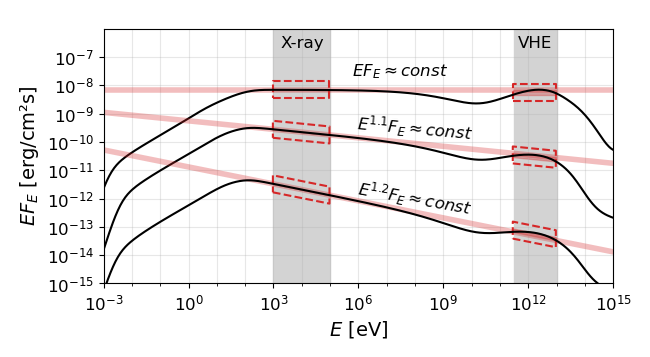

In [15]:
sfc.fullWidth(aspectRatio=0.55)
fig, ax = plt.subplots()

# observational ranges
ylim=[1e-18, 1e-5]
ymax_obs = ylim[1]
dlgobs=-0.7
ymin_obs = 10**dlgobs * ymax_obs
Emins_obs=[1e3, 3e11]
Emaxs_obs=[1e5, 1e13]
E1_eV=1e3
E2_eV=1e5
E3_eV=3e11
E4_eV=1e13
E5_eV=1e8
E6_eV=1e10
DX=0.1
XI=int(np.log(511e3/1e-6) * 10) 
dps=[0, 0.1, 0.2]
flim_keV=0.3
flim_TeV=0.3
flim_GeV=0.3

color_obs="lightgrey"
labels_obs=[r"X-ray", r"VHE"]
for i in range(len(Emins_obs)):
    ax.text(np.sqrt(Emins_obs[i]*Emaxs_obs[i]), 3e-7,
            labels_obs[i], va="center", ha="center", ma="center", color="k")
ax.axvspan(1e3, 1e5, color=color_obs, alpha=1)
ax.axvspan(10**11.5, 1e13, color=color_obs)

for am3, fac, k in [(am3_0, 1, 0),(am3_1, 3e-3, 1),(am3_2, 1e-4, 2)]:
    Gamma, n, t_obs, epsilon_B, epsilon_e, epsilon_p, p, Emin, eta, *rest = scenarios.loc[index]
    eta=1
    epsilon_B *= 2
    t_dyn = Gamma * t_obs
    p_ram = n*Gamma**2*c.mpc2

    t_esc = t_dyn
    
    tesc = Gamma * t_obs
    r = (4-w)*Gamma**2 * t_obs * c.c
    V = 4*np.pi * r**3 / Gamma

    Egobs_eV = Eobs_av(Eg_eV, 0, Gamma)
    Egdp = (Egobs_eV / E1_eV)**dps[k]  # factor (E/E1)**dp

    Ftot = V*dens2flux_av(fac*am3.get_photons()*Eg_erg, tesc, z, Gamma)

    # ax.loglog(Egobs_eV, Ftot, color="k")

    # filter for boxes
    i1 = int(np.log(E1_eV/511e3/Gamma)/DX + XI)
    di1 = int(np.log(E2_eV/E1_eV)/DX)
    i3 = int(np.log(E3_eV/511e3/Gamma)/DX + XI)
    di3 = int(np.log(E4_eV/E3_eV)/DX)
    i5 = int(np.log(E5_eV/511e3/Gamma)/DX + XI)
    di5 = int(np.log(E6_eV/E5_eV)/DX)

    NLepG = len(Eg_eV)
    allinds = np.arange(NLepG)
    indskeVs = np.ones(NLepG, dtype=bool) * np.greater_equal(
        allinds, i1) * np.less_equal(allinds, (i1+di1))
    indsTeVs = np.ones(NLepG, dtype=bool) * np.greater_equal(
        allinds, i3) * np.less_equal(allinds, (i3+di3))
    indsGeVs = np.ones(NLepG, dtype=bool) * np.greater_equal(
        allinds, i5) * np.less_equal(allinds, (i5+di5))
    EFEkeVs = (Egdp*Ftot)[indskeVs]
    EFETeVs = (Egdp*Ftot)[indsTeVs]
    EFEGeVs = (Egdp*Ftot)[indsGeVs]
    min_keVs = np.min(EFEkeVs)
    max_keVs = np.max(EFEkeVs)
    avg_keVs = np.sqrt(min_keVs*max_keVs)
    boxmin_keVs = avg_keVs * 10**-flim_keV
    boxmax_keVs = avg_keVs * 10**flim_keV
    ax.loglog(
        [Egobs_eV[indskeVs][0], Egobs_eV[indskeVs][-1], Egobs_eV[indskeVs][-1],
            Egobs_eV[indskeVs][0], Egobs_eV[indskeVs][0]],
        [boxmin_keVs/Egdp[indskeVs][0], boxmin_keVs/Egdp[indskeVs][-1], boxmax_keVs /
            Egdp[indskeVs][-1], boxmax_keVs/Egdp[indskeVs][0], boxmin_keVs/Egdp[indskeVs][0]],
        color="tab:red", ls="--"
    )
    ax.fill_between(Egobs_eV[indskeVs], min_keVs/Egdp[indskeVs],
                    max_keVs/Egdp[indskeVs], alpha=0.3, color="tab:red")
    # ax.fill_between(Egobs_eV[indskeVs], boxmin_keVs/Egdp[indskeVs],
    #                 boxmax_keVs/Egdp[indskeVs], alpha=0.3, color="tab:red")
    ax.loglog(Egobs_eV, avg_keVs/Egdp, alpha=0.3, color="tab:red", lw=4)
    min_TeVs = np.min(EFETeVs)
    max_TeVs = np.max(EFETeVs)
    avg_TeVs = np.sqrt(min_TeVs*max_TeVs)
    boxmin_TeVs = avg_TeVs * 10**-flim_TeV
    boxmax_TeVs = avg_TeVs * 10**flim_TeV
    ax.loglog(
        [Egobs_eV[indsTeVs][0], Egobs_eV[indsTeVs][-1], Egobs_eV[indsTeVs][-1],
            Egobs_eV[indsTeVs][0], Egobs_eV[indsTeVs][0]],
        [boxmin_TeVs/Egdp[indsTeVs][0], boxmin_TeVs/Egdp[indsTeVs][-1], boxmax_TeVs /
            Egdp[indsTeVs][-1], boxmax_TeVs/Egdp[indsTeVs][0], boxmin_TeVs/Egdp[indsTeVs][0]],
        color="tab:red", ls="--"
    )
    ax.fill_between(Egobs_eV[indsTeVs], min_TeVs/Egdp[indsTeVs],
                    max_TeVs/Egdp[indsTeVs], alpha=0.3, color="tab:red")
    # ax.loglog(Egobs_eV, avg_TeVs/Egdp, alpha=0.3, color="tab:red")


    Egdp = 1
    ax.loglog(Egobs_eV, Egdp*Ftot, c="k")

ax.text(3e7, 3e-8, r"$E F_E \approx const$" , va="center", ha="center", ma="center", color="k")
ax.text(1e8, 3e-10, r"$E^{1.1} F_E \approx const$" , va="center", ha="center", ma="center", color="k", rotation=-5)
ax.text(1e8, 1e-12, r"$E^{1.2} F_E \approx const$" , va="center", ha="center", ma="center", color="k", rotation=-10)

ax.set_ylim(1e-15, 1e-6)
ax.set_yticks(10**np.arange(-15., -6.1,))

ax.set_xlim(1e-3, 1e15)
ax.set_xticks(10**np.arange(-3., 16., 3))
ax.set_xticks(10**np.arange(-3., 16., 1), minor=True)
ax.set_xticklabels(["" for a in np.arange(-3., 16., 1)], minor=True)
# ax.legend(framealpha=1, loc="lower left")
ax.set_xlabel(r"$E$ [eV]")
ax.set_ylabel(r"$E F_E$ [erg/cm²s]")
ax.set_aspect("equal")
ax.grid(alpha=0.3, which="both")
# ax.set_title(r"'flat' scenario selection", loc="left")
fig.tight_layout()
sfc.saveFigure(fig, f"conceptualplot")